In [1]:
import warnings
warnings.filterwarnings('ignore')


import time

def seconds_to_hms(seconds):
    # Convert seconds to hours, minutes, and seconds
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    # Return formatted string
    return "%d hr:%02d min:%02d sec" % (h, m, s)


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision.utils import save_image
import torchvision.utils as vutils

import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import random



In [3]:
class AnimalFacesDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None, target_transform=None, train=True):
        super(AnimalFacesDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.train = train
        path = root  # Use root directly without appending 'train' or 'val'
        
        self.data = []
        self.targets = []
        self.classes = ['cat', 'dog', 'wild']
        self.class_to_idx = {'cat': 0, 'dog': 1, 'wild': 2}
        self.class_counts = {class_name: 0 for class_name in self.classes}
        
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(label)
                self.class_counts[class_name] += 1  # Update class count
        
    def __getitem__(self, index):
        img_path, target = self.data[index], self.targets[index]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, target
    
    def __len__(self):
        return len(self.data)
    
    def get_class_counts(self):
        return self.class_counts

In [4]:
# Hyperparameters 

# Define number of workers and GPUs
NUM_WORKERS = 4  # how many subprocesses to use for data loading. 

# Define the number of channels in the image: 3 for RGB
CHANNELS_IMG = 3
IMAGE_SIZE = 128 # input image resolution


LEARNING_RATE = 0.0002  #2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128  # DCGAN paper recommendation
FEATURES_DISC = 128  # ndf
FEATURES_GEN = 128   # ngf

NOISE_DIM = 128  # nz

NUM_EPOCHS = 100

# Adam  
BETA1 = 0.5  # momentum term
BETA2 = 0.999   # exponential average


In [5]:


# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)] # mean of 0.5 and a standard deviation of 0.5. 
    ),
])



train_dataset = AnimalFacesDataset(root='afhq/train', transform=transform, train=True)
val_dataset = AnimalFacesDataset(root='afhq/val', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



print(f'Train data samples: ', len(train_dataset))
print(f'Validation data samples: ', len(val_dataset))


# Printing each class size with class names for training dataset
train_class_counts = train_dataset.get_class_counts()
for class_name, count in train_class_counts.items():
    print(f"Training samples for class {class_name}: {count}")

# Printing each class size with class names for validation dataset
val_class_counts = val_dataset.get_class_counts()
for class_name, count in val_class_counts.items():
    print(f"Validation samples for class {class_name}: {count}")

Train data samples:  14630
Validation data samples:  1500
Training samples for class cat: 5153
Training samples for class dog: 4739
Training samples for class wild: 4738
Validation samples for class cat: 500
Validation samples for class dog: 500
Validation samples for class wild: 500


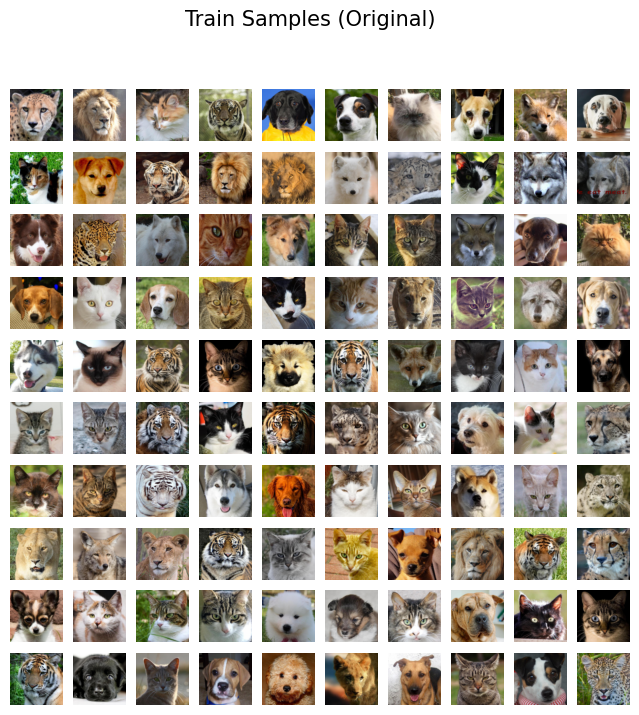

In [6]:


def imshow(img):
    # Denormalize the image
    img = img * 0.5 + 0.5  # This will bring your image range to [0..1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # No axes for a cleaner image


# Randomly sample 100 images from train_dataset
random_indices = random.sample(range(len(train_dataset)), 100)
random_images = [train_dataset[i][0] for i in random_indices]

# Plot images in a grid
fig = plt.figure(figsize=(8, 8))
for idx, img in enumerate(random_images):
    ax = fig.add_subplot(10, 10, idx + 1, xticks=[], yticks=[])
    imshow(img)

# Add title to the figure
fig.suptitle("Train Samples (Original)", fontsize=15)


plt.show()


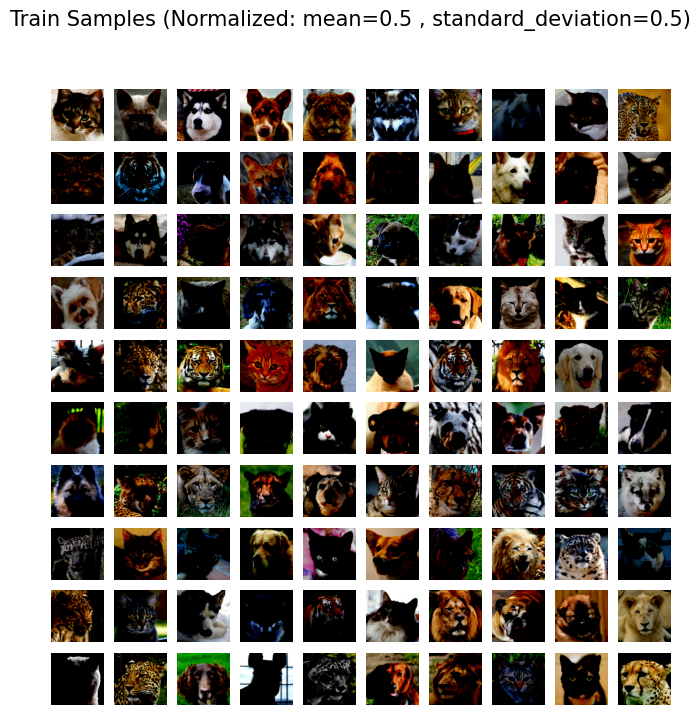

In [7]:


def imshow(img):
    # Convert from tensor image
    img = img.numpy().transpose((1, 2, 0))
    # Clip the image data to ensure it is within the valid range
    # This is a quick fix; a better approach might be actual min-max normalization as shown below
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes ticks and numbers


# Randomly sample 100 images from train_dataset
random_indices = random.sample(range(len(train_dataset)), 100)
random_images = [train_dataset[i][0] for i in random_indices]

# Plot images in a grid
fig = plt.figure(figsize=(8, 8))
for idx, img in enumerate(random_images):
    ax = fig.add_subplot(10, 10, idx + 1, xticks=[], yticks=[])
    imshow(img)

# Add title to the figure
fig.suptitle("Train Samples (Normalized: mean=0.5 , standard_deviation=0.5)", fontsize=15)

plt.show()


In [8]:
# DCGAN architecture with input image size 128x128

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        # Additional layer for 128x128 images
        self.disc = nn.Sequential(
            # input: N x channels_img x 128 x 128
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # no BatchNorm in 1st layer   # DCGAN paper
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            # Now image is 64x64
            self._block(features_d, features_d * 2, 4, 2, 1),
            # Now image is 32x32
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # Now image is 16x16
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # Now image is 8x8
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # Now image is 4x4
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=2, padding=0),
            # Now image is 1x1
             # last layer, no BatchNorm
            nn.Sigmoid(),    
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),   # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # img: 32x32
            # Additional layer for 128x128 images
            self._block(features_g * 2, features_g, 4, 2, 1),       # img: 64x64
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1), # img: 128x128
            nn.Tanh()  # Output: N x channels_img x 128 x 128
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 128, 3, 128, 128  # Adjusted for 128x128 images, N: batch_size
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 64)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 64)
    initialize_weights(gen)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

if __name__ == "__main__":
    test()


Success, tests passed!


In [9]:
# Test and display DCGAN architecture

# Instantiate the generator and discriminator
nz = 100  # Size of z latent vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in generator
nc = 3    # Number of channels in the training images. For color images this is 3
ndf = 64  # Size of feature maps in discriminator

# Create the generator and discriminator
gen = Generator(nz, nc, ngf)
disc = Discriminator(nc, ndf)



# Apply the weights initialization function to the models
initialize_weights(gen)
initialize_weights(disc)

print(gen, disc)    
    

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

In [10]:

# Specify the GPUs you want to use
gpu_ids = [1, 3, 5, 6, 7]
available_gpu_ids = list(range(torch.cuda.device_count()))

# Check if the specified GPUs are in the list of available GPUs
if not all(gpu in available_gpu_ids for gpu in gpu_ids):
    raise ValueError("One or more GPU ids specified are not available.")

# Assuming that the first GPU in the list will be the primary one
torch.cuda.set_device(gpu_ids[0])
device = torch.device(f"cuda:{gpu_ids[0]}" if torch.cuda.is_available() else "cpu")  

# Instantiate the Generator and Discriminator models with hyperparameters
netG = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
netD = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights function
initialize_weights(netG)
initialize_weights(netD)

# Wrap the generator and the discriminator in DataParallel with specific GPUs
if len(gpu_ids) > 1:
    print("Using GPUs:", gpu_ids)
    netG = nn.DataParallel(netG, device_ids=gpu_ids)
    netD = nn.DataParallel(netD, device_ids=gpu_ids)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1, device=device)

print(f"Primary device (parameters): {device}")


Using GPUs: [1, 3, 5, 6, 7]
Primary device (parameters): cuda:1


In [11]:

# Directory setup: Define directories for saving single and multiple images
image_dir = "dcgan_generated_images_1"
os.makedirs(image_dir, exist_ok=True)
single_image_dir = os.path.join(image_dir, 'single_images')
multiple_image_dir = os.path.join(image_dir, 'multiple_images')
os.makedirs(single_image_dir, exist_ok=True)
os.makedirs(multiple_image_dir, exist_ok=True)

In [12]:

# Lists to hold average losses and accuracy across all epochs
avg_loss_disc_epoch_list = []
avg_loss_gen_epoch_list = []
avg_acc_disc_epoch_list = []



# Define a fixed set of noise vectors before the training loop starts
# This will be used to generate the same set of images over time
num_images_grid = 100  # 10x10 images
fixed_noise_for_evaluation = torch.randn(num_images_grid, NOISE_DIM, 1, 1, device=device)  


print("Starting Training DCGAN...\n")
start_time = time.time()  # Start time for total training time calculation
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()  # Start time for the epoch
    
    
    # Lists to hold losses and accuracies for each batch
    loss_disc_list = []
    loss_gen_list = []
    acc_disc_list = []

    
    for batch_id, (real, _) in enumerate(train_loader):  # Target labels not needed! : unsupervised
        real = real.to(device)  #shape (128x3x128x128)
        b_size = real.size(0)  # dynamically calculate batch_size as last batch is smaller than 128(BATCH_SIZE).
        noise = torch.randn(b_size, NOISE_DIM, 1, 1, device=device)
        fake = netG(noise) # Generate fake images

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        disc_real = netD(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = netD(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) #/ 2
        loss_disc.backward()
        optimizerD.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        netG.zero_grad()
        output_gen = netD(fake).view(-1)
        loss_gen = criterion(output_gen, torch.ones_like(output_gen))
        loss_gen.backward()
        optimizerG.step()

        # Calculate discriminator accuracy
        with torch.no_grad():
            pred_real = disc_real > 0.5
            pred_fake = disc_fake <= 0.5
            acc_real = torch.mean(pred_real.float())
            acc_fake = torch.mean(pred_fake.float())
            acc_disc_batch = (acc_real + acc_fake) / 2

        # Append losses and accuracy to lists
        loss_disc_list.append(loss_disc.item())
        loss_gen_list.append(loss_gen.item())
        acc_disc_list.append(acc_disc_batch.item())

        # Print losses occasionally
        if batch_id % 32 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] (Batch {batch_id+1}/{len(train_loader)}) \t"
                  f"DISC loss: {loss_disc:.4f}, GEN loss: {loss_gen:.4f}, DISC Accuracy: {acc_disc_batch:.4f}")

  

    # End of epoch - Calculate average loss and accuracy for the epoch
    avg_loss_disc_epoch = sum(loss_disc_list) / len(loss_disc_list)
    avg_loss_gen_epoch = sum(loss_gen_list) / len(loss_gen_list)
    avg_acc_disc_epoch = sum(acc_disc_list) / len(acc_disc_list)
    avg_loss_disc_epoch_list.append(avg_loss_disc_epoch)
    avg_loss_gen_epoch_list.append(avg_loss_gen_epoch)
    avg_acc_disc_epoch_list.append(avg_acc_disc_epoch)

    # Print average stats at the end of the epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} completed in {epoch_duration:.4f} secs:\t'
          f'Avg Loss DISC: {avg_loss_disc_epoch:.4f}, Avg Loss GEN: {avg_loss_gen_epoch:.4f}, '
          f'Avg Accuracy DISC: {avg_acc_disc_epoch:.4f} \n \n')

    # Periodic evaluation and image saving
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1:
        with torch.no_grad():
            # Generate a batch of fake images using the fixed noise
            netG.eval()
            fake_fixed = netG(fixed_noise_for_evaluation).detach().cpu()  # forward propagation

            # Save single image
            single_image = torchvision.utils.make_grid(fake_fixed[:1], normalize=True)
            torchvision.utils.save_image(single_image, os.path.join(single_image_dir, f"single_fake_{epoch+1:04d}.png"))

            # Save grid of images (10x10)
            grid_images = torchvision.utils.make_grid(fake_fixed[:100], nrow=10, normalize=True)
            torchvision.utils.save_image(grid_images, os.path.join(multiple_image_dir, f"multiple_fake_{epoch+1:04d}.png"))

        netG.train()  # Back to train mode
               
            
            

# Training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time(seconds): {training_time:.2f} seconds")
print(f"Total Training time: {seconds_to_hms(training_time)}")

print('\n')

Starting Training DCGAN...

Epoch [1/100] (Batch 1/115) 	DISC loss: 1.4127, GEN loss: 1.4411, DISC Accuracy: 0.1484
Epoch [1/100] (Batch 33/115) 	DISC loss: 0.0156, GEN loss: 5.3062, DISC Accuracy: 1.0000
Epoch [1/100] (Batch 65/115) 	DISC loss: 0.0053, GEN loss: 6.2771, DISC Accuracy: 1.0000
Epoch [1/100] (Batch 97/115) 	DISC loss: 1.3287, GEN loss: 1.1496, DISC Accuracy: 0.6719
Epoch 1/100 completed in 18.1475 secs:	Avg Loss DISC: 0.4269, Avg Loss GEN: 4.2909, Avg Accuracy DISC: 0.9002 
 

Epoch [2/100] (Batch 1/115) 	DISC loss: 0.5897, GEN loss: 2.3896, DISC Accuracy: 0.8672
Epoch [2/100] (Batch 33/115) 	DISC loss: 0.0395, GEN loss: 5.9276, DISC Accuracy: 1.0000
Epoch [2/100] (Batch 65/115) 	DISC loss: 0.9570, GEN loss: 2.8871, DISC Accuracy: 0.8047
Epoch [2/100] (Batch 97/115) 	DISC loss: 0.9059, GEN loss: 2.8562, DISC Accuracy: 0.7812
Epoch 2/100 completed in 10.3467 secs:	Avg Loss DISC: 0.6982, Avg Loss GEN: 3.1754, Avg Accuracy DISC: 0.8522 
 

Epoch [3/100] (Batch 1/115) 	DISC 

Epoch [18/100] (Batch 65/115) 	DISC loss: 0.6595, GEN loss: 3.6063, DISC Accuracy: 0.8906
Epoch [18/100] (Batch 97/115) 	DISC loss: 0.6337, GEN loss: 3.2436, DISC Accuracy: 0.8984
Epoch 18/100 completed in 11.9712 secs:	Avg Loss DISC: 0.8214, Avg Loss GEN: 3.6254, Avg Accuracy DISC: 0.8150 
 

Epoch [19/100] (Batch 1/115) 	DISC loss: 0.5823, GEN loss: 4.0917, DISC Accuracy: 0.9219
Epoch [19/100] (Batch 33/115) 	DISC loss: 0.6386, GEN loss: 2.5350, DISC Accuracy: 0.8867
Epoch [19/100] (Batch 65/115) 	DISC loss: 0.7397, GEN loss: 3.2848, DISC Accuracy: 0.8516
Epoch [19/100] (Batch 97/115) 	DISC loss: 0.7888, GEN loss: 3.1357, DISC Accuracy: 0.8594
Epoch 19/100 completed in 11.0703 secs:	Avg Loss DISC: 0.8129, Avg Loss GEN: 3.6882, Avg Accuracy DISC: 0.8233 
 

Epoch [20/100] (Batch 1/115) 	DISC loss: 1.2168, GEN loss: 5.7752, DISC Accuracy: 0.6211
Epoch [20/100] (Batch 33/115) 	DISC loss: 0.6649, GEN loss: 2.7828, DISC Accuracy: 0.9062
Epoch [20/100] (Batch 65/115) 	DISC loss: 1.0585, GE

Epoch 35/100 completed in 11.1455 secs:	Avg Loss DISC: 0.5334, Avg Loss GEN: 4.6058, Avg Accuracy DISC: 0.8935 
 

Epoch [36/100] (Batch 1/115) 	DISC loss: 0.4870, GEN loss: 4.4181, DISC Accuracy: 0.9258
Epoch [36/100] (Batch 33/115) 	DISC loss: 1.0399, GEN loss: 7.4890, DISC Accuracy: 0.6875
Epoch [36/100] (Batch 65/115) 	DISC loss: 0.5586, GEN loss: 6.0208, DISC Accuracy: 0.8672
Epoch [36/100] (Batch 97/115) 	DISC loss: 0.7707, GEN loss: 4.1342, DISC Accuracy: 0.8086
Epoch 36/100 completed in 10.2211 secs:	Avg Loss DISC: 0.5265, Avg Loss GEN: 4.7548, Avg Accuracy DISC: 0.8954 
 

Epoch [37/100] (Batch 1/115) 	DISC loss: 0.7020, GEN loss: 7.0928, DISC Accuracy: 0.8320
Epoch [37/100] (Batch 33/115) 	DISC loss: 0.6200, GEN loss: 7.4046, DISC Accuracy: 0.8555
Epoch [37/100] (Batch 65/115) 	DISC loss: 0.3750, GEN loss: 3.6523, DISC Accuracy: 0.9180
Epoch [37/100] (Batch 97/115) 	DISC loss: 1.0471, GEN loss: 7.9883, DISC Accuracy: 0.7070
Epoch 37/100 completed in 11.0060 secs:	Avg Loss DIS

Epoch [53/100] (Batch 33/115) 	DISC loss: 0.3275, GEN loss: 4.3548, DISC Accuracy: 0.9453
Epoch [53/100] (Batch 65/115) 	DISC loss: 0.2596, GEN loss: 5.6372, DISC Accuracy: 0.9805
Epoch [53/100] (Batch 97/115) 	DISC loss: 0.2258, GEN loss: 4.7766, DISC Accuracy: 0.9766
Epoch 53/100 completed in 10.3080 secs:	Avg Loss DISC: 0.3681, Avg Loss GEN: 5.5422, Avg Accuracy DISC: 0.9331 
 

Epoch [54/100] (Batch 1/115) 	DISC loss: 0.3661, GEN loss: 5.1099, DISC Accuracy: 0.9414
Epoch [54/100] (Batch 33/115) 	DISC loss: 0.5013, GEN loss: 8.6429, DISC Accuracy: 0.9102
Epoch [54/100] (Batch 65/115) 	DISC loss: 0.4310, GEN loss: 7.2496, DISC Accuracy: 0.9414
Epoch [54/100] (Batch 97/115) 	DISC loss: 0.3288, GEN loss: 6.4814, DISC Accuracy: 0.9453
Epoch 54/100 completed in 10.9235 secs:	Avg Loss DISC: 0.3198, Avg Loss GEN: 5.2665, Avg Accuracy DISC: 0.9482 
 

Epoch [55/100] (Batch 1/115) 	DISC loss: 0.3952, GEN loss: 9.1816, DISC Accuracy: 0.9141
Epoch [55/100] (Batch 33/115) 	DISC loss: 0.6284, GE

Epoch [70/100] (Batch 97/115) 	DISC loss: 0.1230, GEN loss: 5.2018, DISC Accuracy: 0.9961
Epoch 70/100 completed in 10.0726 secs:	Avg Loss DISC: 0.2378, Avg Loss GEN: 5.3058, Avg Accuracy DISC: 0.9619 
 

Epoch [71/100] (Batch 1/115) 	DISC loss: 0.7325, GEN loss: 11.6452, DISC Accuracy: 0.8164
Epoch [71/100] (Batch 33/115) 	DISC loss: 0.2331, GEN loss: 6.2749, DISC Accuracy: 0.9805
Epoch [71/100] (Batch 65/115) 	DISC loss: 0.2791, GEN loss: 4.9293, DISC Accuracy: 0.9492
Epoch [71/100] (Batch 97/115) 	DISC loss: 0.1997, GEN loss: 4.8980, DISC Accuracy: 0.9805
Epoch 71/100 completed in 10.6881 secs:	Avg Loss DISC: 0.4387, Avg Loss GEN: 5.2868, Avg Accuracy DISC: 0.9275 
 

Epoch [72/100] (Batch 1/115) 	DISC loss: 1.2312, GEN loss: 13.7920, DISC Accuracy: 0.6875
Epoch [72/100] (Batch 33/115) 	DISC loss: 0.2340, GEN loss: 3.9482, DISC Accuracy: 0.9727
Epoch [72/100] (Batch 65/115) 	DISC loss: 0.1913, GEN loss: 5.0157, DISC Accuracy: 0.9727
Epoch [72/100] (Batch 97/115) 	DISC loss: 0.2822, 

Epoch [88/100] (Batch 1/115) 	DISC loss: 0.2599, GEN loss: 5.9026, DISC Accuracy: 0.9531
Epoch [88/100] (Batch 33/115) 	DISC loss: 0.2243, GEN loss: 5.3426, DISC Accuracy: 0.9727
Epoch [88/100] (Batch 65/115) 	DISC loss: 0.4065, GEN loss: 4.3366, DISC Accuracy: 0.9023
Epoch [88/100] (Batch 97/115) 	DISC loss: 0.1403, GEN loss: 5.7839, DISC Accuracy: 0.9844
Epoch 88/100 completed in 10.8143 secs:	Avg Loss DISC: 0.1814, Avg Loss GEN: 5.1425, Avg Accuracy DISC: 0.9797 
 

Epoch [89/100] (Batch 1/115) 	DISC loss: 0.3348, GEN loss: 9.1984, DISC Accuracy: 0.9414
Epoch [89/100] (Batch 33/115) 	DISC loss: 0.1271, GEN loss: 4.5030, DISC Accuracy: 0.9883
Epoch [89/100] (Batch 65/115) 	DISC loss: 0.1424, GEN loss: 5.1272, DISC Accuracy: 0.9922
Epoch [89/100] (Batch 97/115) 	DISC loss: 0.3663, GEN loss: 10.8936, DISC Accuracy: 0.9375
Epoch 89/100 completed in 10.3403 secs:	Avg Loss DISC: 0.2113, Avg Loss GEN: 5.6780, Avg Accuracy DISC: 0.9684 
 

Epoch [90/100] (Batch 1/115) 	DISC loss: 0.1961, GE

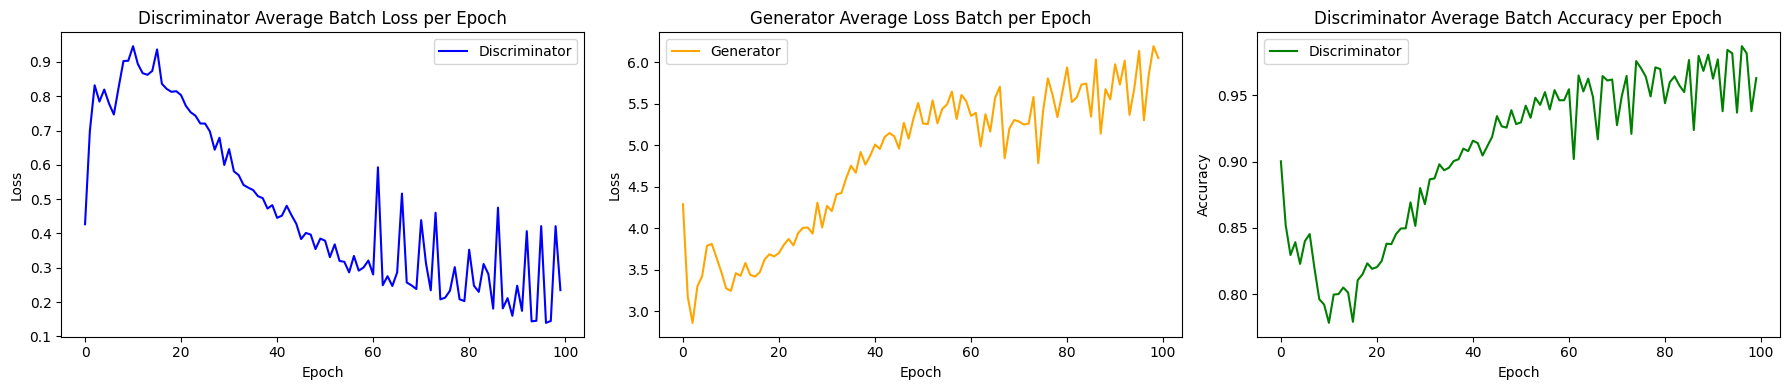

In [13]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Plot Discriminator average loss
axs[0].plot(avg_loss_disc_epoch_list, label='Discriminator', color='blue')
axs[0].set_title("Discriminator Average Batch Loss per Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot Generator average loss
axs[1].plot(avg_loss_gen_epoch_list, label='Generator', color='orange')
axs[1].set_title("Generator Average Loss Batch per Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

# Plot Discriminator average accuracy
axs[2].plot(avg_acc_disc_epoch_list, label='Discriminator', color='green')
axs[2].set_title("Discriminator Average Batch Accuracy per Epoch")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Accuracy")
axs[2].legend()

# Adjust the layout so that the plots are not overlapping
plt.tight_layout()
plt.show()


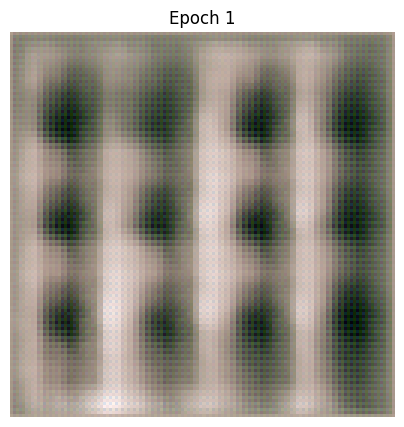

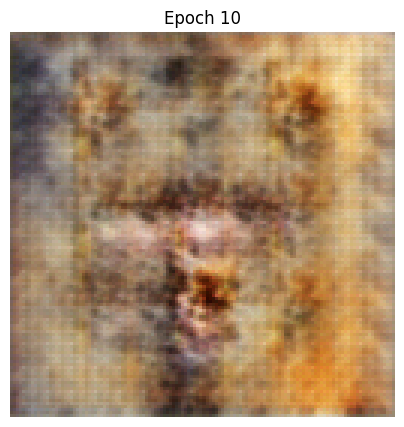

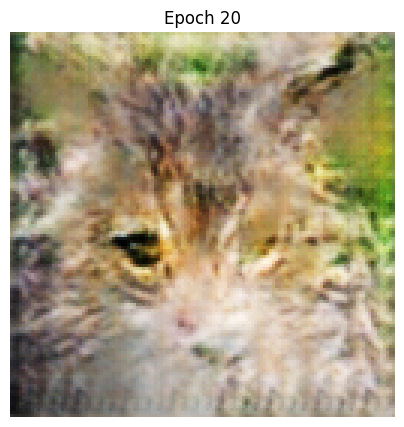

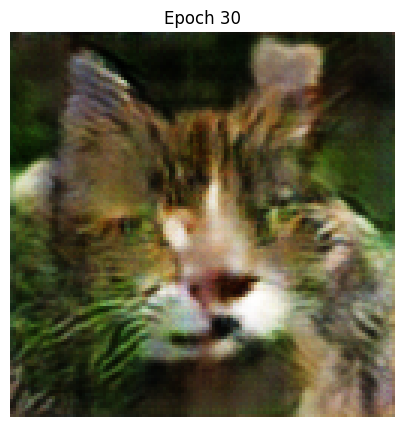

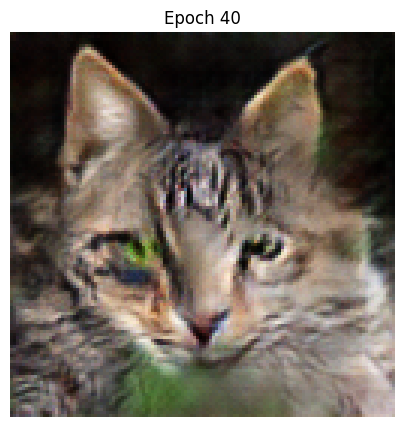

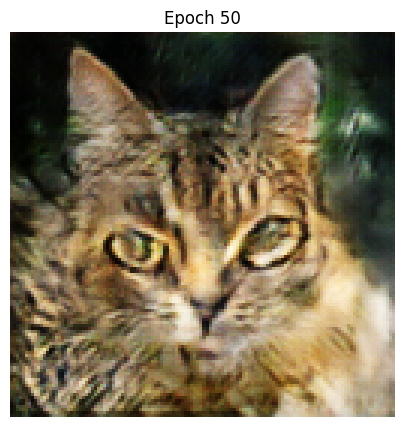

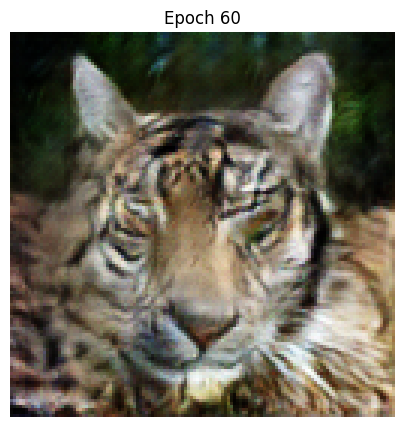

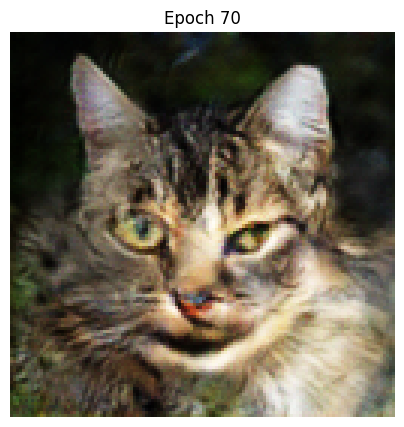

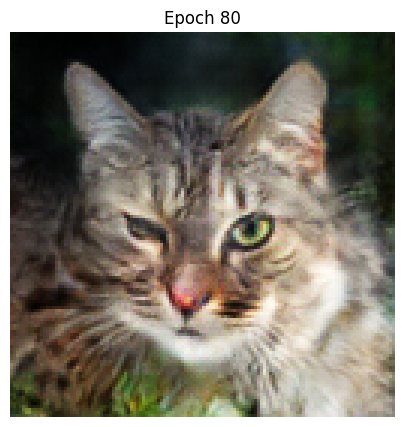

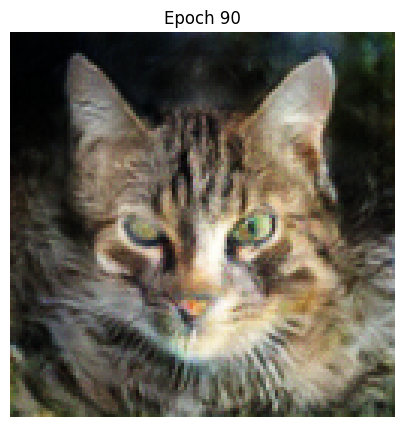

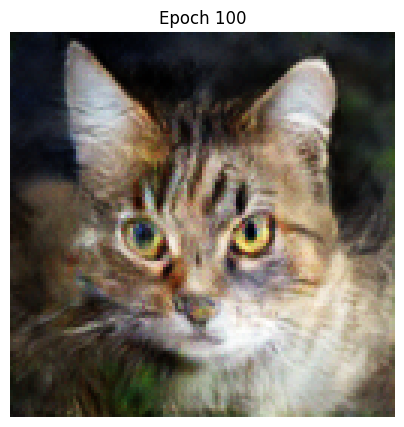

In [14]:

# Directory where the images are saved
image_dir = "dcgan_generated_images_1/single_images"


# Display the images
for epoch in range(0, NUM_EPOCHS + 1, 10):  # Start at epoch 1, end at NUM_EPOCHS, step by 10
    # Correctly format the filename with leading zeros up to four digits
    filename = f"single_fake_{epoch:04d}.png"
    filepath = os.path.join(image_dir, filename)
    
    # Check if the image file exists
    if os.path.exists(filepath):
        img = plt.imread(filepath)
        plt.figure(figsize=(5, 5))  # Adjust the size as needed
        plt.title(f"Epoch {epoch}")
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()
    elif epoch == 0:
        filename = f"single_fake_{epoch+1:04d}.png"
        filepath = os.path.join(image_dir, filename)
        img = plt.imread(filepath)
        plt.figure(figsize=(5, 5))  # Adjust the size as needed
        plt.title(f"Epoch {epoch+1}")
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

    else:
        print(f"Image file {filename} does not exist.")


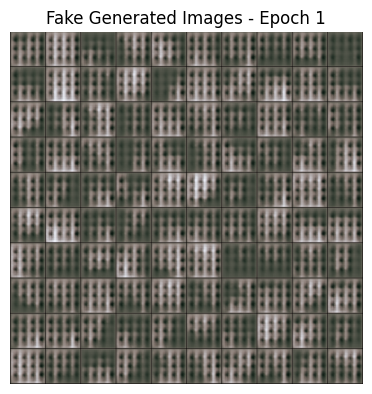

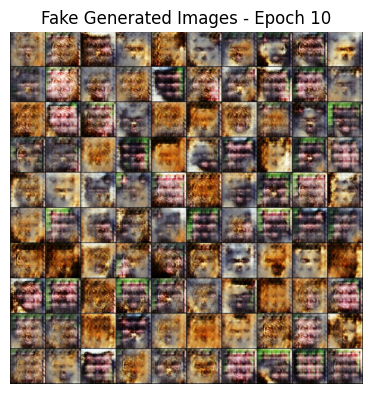

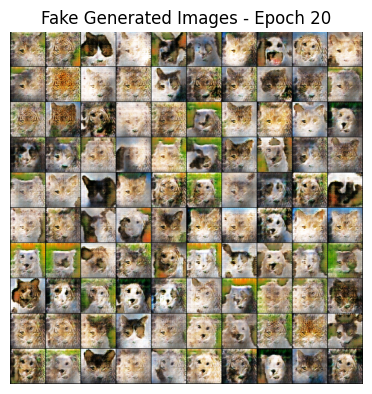

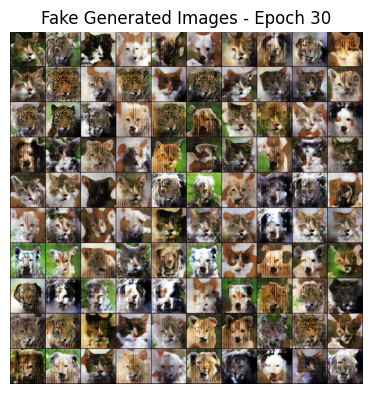

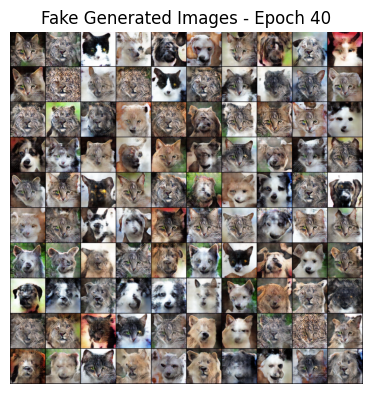

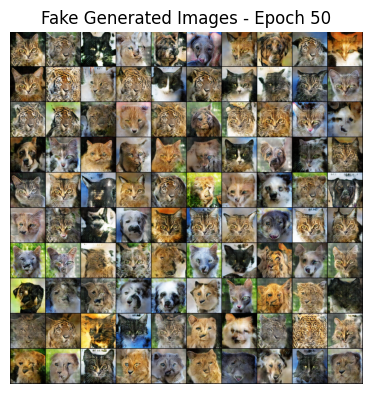

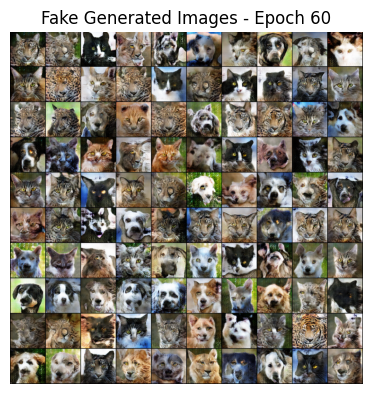

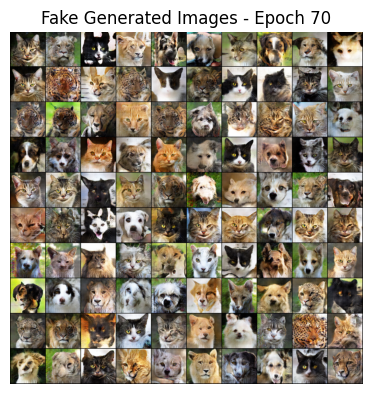

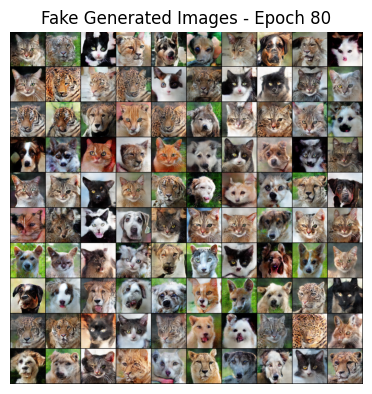

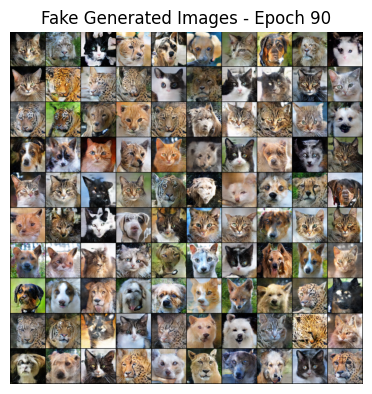

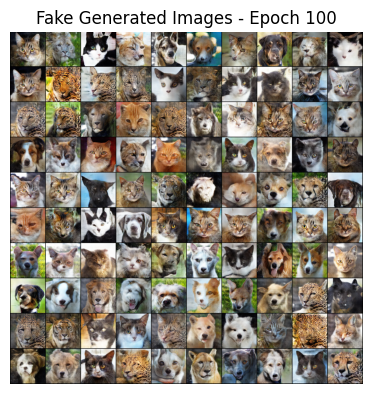

In [15]:

# Directory where the images are saved
image_dir = "dcgan_generated_images_1/multiple_images"


# No need to compare real vs fake(generated) like VAEs as we are not reconstructing here.

# Output images for every 10 epochs
for i in range(0, NUM_EPOCHS + 1 , 10):
    fake_filename = f"multiple_fake_{i:04d}.png"
    
    fake_filepath = os.path.join(image_dir, fake_filename)

    if os.path.exists(fake_filepath):
        fake_image = plt.imread(fake_filepath)

        plt.figure(figsize=(10, 10))
    

        # Plot fake images
        plt.subplot(1, 2, 2)
        plt.title(f"Fake Generated Images - Epoch {i}")
        plt.imshow(fake_image)
        plt.axis('off')

        plt.show()
        
    elif i == 0:
        fake_filename = f"multiple_fake_{i+1:04d}.png"
    
        fake_filepath = os.path.join(image_dir, fake_filename)
        fake_image = plt.imread(fake_filepath)
        plt.figure(figsize=(10, 10))

        # Plot fake images
        plt.subplot(1, 2, 2)
        plt.title(f"Fake Generated Images - Epoch {i+1}")
        plt.imshow(fake_image)
        plt.axis('off')

        plt.show() 
        
    else:
        print(f"Image files {fake_filename} or {real_filename} do not exist.")
